In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

### 1.Load Data from Step 1
Read the cleaned returns data that we prepared.

In [2]:
# Load the cleaned returns data
returns = pd.read_csv('cleaned_returns.csv', index_col=0, parse_dates=True)

print(f"Data loaded successfully!")
print(f"Assets: {', '.join(returns.columns)}")
print(f"Observations: {len(returns)}")
print(f"Date Range: {returns.index[0].date()} to {returns.index[-1].date()}")

Data loaded successfully!
Assets: AAPL, MSFT, JPM, GLD, SPY
Observations: 750
Date Range: 2022-11-08 to 2025-11-04


### 2.Portfolio Configuration
Set up our portfolio parameters:
- Portfolio value: $1,000,000
- Confidence level: 99%
- Asset weights: Equal allocation across all assets

Calculate Portfolio Returns: Combine individual asset returns into a single portfolio return using our weights.

In [3]:
# Portfolio parameters
portfolio_value = 1_000_000  # $1 million portfolio
confidence_level = 0.99      # 99% confidence level
alpha = 1 - confidence_level # 1% tail

# Portfolio weights (equal-weighted for simplicity)
n_assets = len(returns.columns)
weights = np.array([1/n_assets] * n_assets)

print(f"Portfolio Value: ${portfolio_value:,.0f}")
print(f"Confidence Level: {confidence_level*100}%")
print(f"Significance Level (α): {alpha*100}%")
print(f"Asset Allocation (Equal-Weighted):")
for i, ticker in enumerate(returns.columns):
    print(f"   {ticker}: {weights[i]*100:.1f}% (${portfolio_value*weights[i]:,.0f})")

# Calculate portfolio returns
portfolio_returns = (returns * weights).sum(axis=1)

print(f"Portfolio returns calculated")
print(f"Mean daily return: {portfolio_returns.mean():.4f} ({portfolio_returns.mean()*100:.2f}%)")
print(f"Daily volatility: {portfolio_returns.std():.4f} ({portfolio_returns.std()*100:.2f}%)")


Portfolio Value: $1,000,000
Confidence Level: 99.0%
Significance Level (α): 1.0000000000000009%
Asset Allocation (Equal-Weighted):
   AAPL: 20.0% ($200,000)
   MSFT: 20.0% ($200,000)
   JPM: 20.0% ($200,000)
   GLD: 20.0% ($200,000)
   SPY: 20.0% ($200,000)
Portfolio returns calculated
Mean daily return: 0.0011 (0.11%)
Daily volatility: 0.0094 (0.94%)


In [4]:
# Sort returns and find the percentile
sorted_returns = np.sort(portfolio_returns)
var_historical_return = np.percentile(sorted_returns, alpha * 100)
var_historical_dollar = portfolio_value * abs(var_historical_return)

print(f"Historical Simulation Approach:")
print(f"- Uses {len(portfolio_returns)} historical daily returns")
print(f"- Finds the {alpha*100}% percentile of actual losses")
print(f"Results:")
print(f"99% VaR (return): {var_historical_return:.4f} ({var_historical_return*100:.2f}%)")
print(f"99% VaR (dollar): ${var_historical_dollar:,.2f}")
print(f"Interpretation:")
print(f"We are 99% confident that portfolio losses will not exceed")
print(f"${var_historical_dollar:,.2f} in a single day.")

Historical Simulation Approach:
- Uses 750 historical daily returns
- Finds the 1.0000000000000009% percentile of actual losses
Results:
99% VaR (return): -0.0215 (-2.15%)
99% VaR (dollar): $21,543.70
Interpretation:
We are 99% confident that portfolio losses will not exceed
$21,543.70 in a single day.


In [5]:
# Calculate mean and standard deviation
portfolio_mean = portfolio_returns.mean()
portfolio_std = portfolio_returns.std()

# Get z-score for 99% confidence (left tail)
z_score = stats.norm.ppf(alpha)

# Calculate VaR
var_parametric_return = portfolio_mean + z_score * portfolio_std
var_parametric_dollar = portfolio_value * abs(var_parametric_return)

print(f"Parametric Approach (Assumes Normal Distribution):")
print(f"- Portfolio mean return: {portfolio_mean:.6f}")
print(f"- Portfolio std deviation: {portfolio_std:.6f}")
print(f"- Z-score at {confidence_level*100}%: {z_score:.4f}")
print(f"Results:")
print(f"99% VaR (return): {var_parametric_return:.4f} ({var_parametric_return*100:.2f}%)")
print(f"99% VaR (dollar): ${var_parametric_dollar:,.2f}")
print(f"Interpretation:")
print(f"Under normal distribution assumption, we are 99% confident")
print(f"that losses will not exceed ${var_parametric_dollar:,.2f} in a single day.")


Parametric Approach (Assumes Normal Distribution):
- Portfolio mean return: 0.001137
- Portfolio std deviation: 0.009376
- Z-score at 99.0%: -2.3263
Results:
99% VaR (return): -0.0207 (-2.07%)
99% VaR (dollar): $20,673.75
Interpretation:
Under normal distribution assumption, we are 99% confident
that losses will not exceed $20,673.75 in a single day.


In [6]:
# Monte Carlo parameters
n_simulations = 10000
np.random.seed(42)  # For reproducibility

print(f"Monte Carlo Approach:")
print(f"- Running {n_simulations:,} simulations")
print(f"- Based on historical mean and covariance")

# Calculate covariance matrix
cov_matrix = returns.cov()

# Generate random returns using multivariate normal distribution
simulated_asset_returns = np.random.multivariate_normal(
    returns.mean().values,
    cov_matrix.values,
    n_simulations
)

# Calculate portfolio returns for each simulation
simulated_portfolio_returns = np.dot(simulated_asset_returns, weights)

# Calculate VaR
var_monte_carlo_return = np.percentile(simulated_portfolio_returns, alpha * 100)
var_monte_carlo_dollar = portfolio_value * abs(var_monte_carlo_return)

print(f"Results:")
print(f"99% VaR (return): {var_monte_carlo_return:.4f} ({var_monte_carlo_return*100:.2f}%)")
print(f"99% VaR (dollar): ${var_monte_carlo_dollar:,.2f}")
print(f"Interpretation:")
print(f"Based on {n_simulations:,} simulated scenarios, we are 99% confident")
print(f"that losses will not exceed ${var_monte_carlo_dollar:,.2f} in a single day.")


Monte Carlo Approach:
- Running 10,000 simulations
- Based on historical mean and covariance
Results:
99% VaR (return): -0.0207 (-2.07%)
99% VaR (dollar): $20,684.42
Interpretation:
Based on 10,000 simulated scenarios, we are 99% confident
that losses will not exceed $20,684.42 in a single day.


In [8]:
# Create comparison table
var_comparison = pd.DataFrame({
    'Method': ['Historical Simulation', 'Variance-Covariance', 'Monte Carlo'],
    'VaR (%)': [var_historical_return*100, var_parametric_return*100, var_monte_carlo_return*100],
    'VaR ($)': [var_historical_dollar, var_parametric_dollar, var_monte_carlo_dollar]
})

print("\n" + var_comparison.to_string(index=False))

# Calculate differences
print(f"\n Method Comparison:")
print(f"Max VaR: ${var_comparison['VaR ($)'].max():,.2f} ({var_comparison.loc[var_comparison['VaR ($)'].idxmax(), 'Method']})")
print(f"Min VaR: ${var_comparison['VaR ($)'].min():,.2f} ({var_comparison.loc[var_comparison['VaR ($)'].idxmin(), 'Method']})")
print(f"Range: ${var_comparison['VaR ($)'].max() - var_comparison['VaR ($)'].min():,.2f}")
print(f"Std Dev: ${var_comparison['VaR ($)'].std():,.2f}")



               Method   VaR (%)      VaR ($)
Historical Simulation -2.154370 21543.699522
  Variance-Covariance -2.067375 20673.750156
          Monte Carlo -2.068442 20684.423528

 Method Comparison:
Max VaR: $21,543.70 (Historical Simulation)
Min VaR: $20,673.75 (Variance-Covariance)
Range: $869.95
Std Dev: $499.21


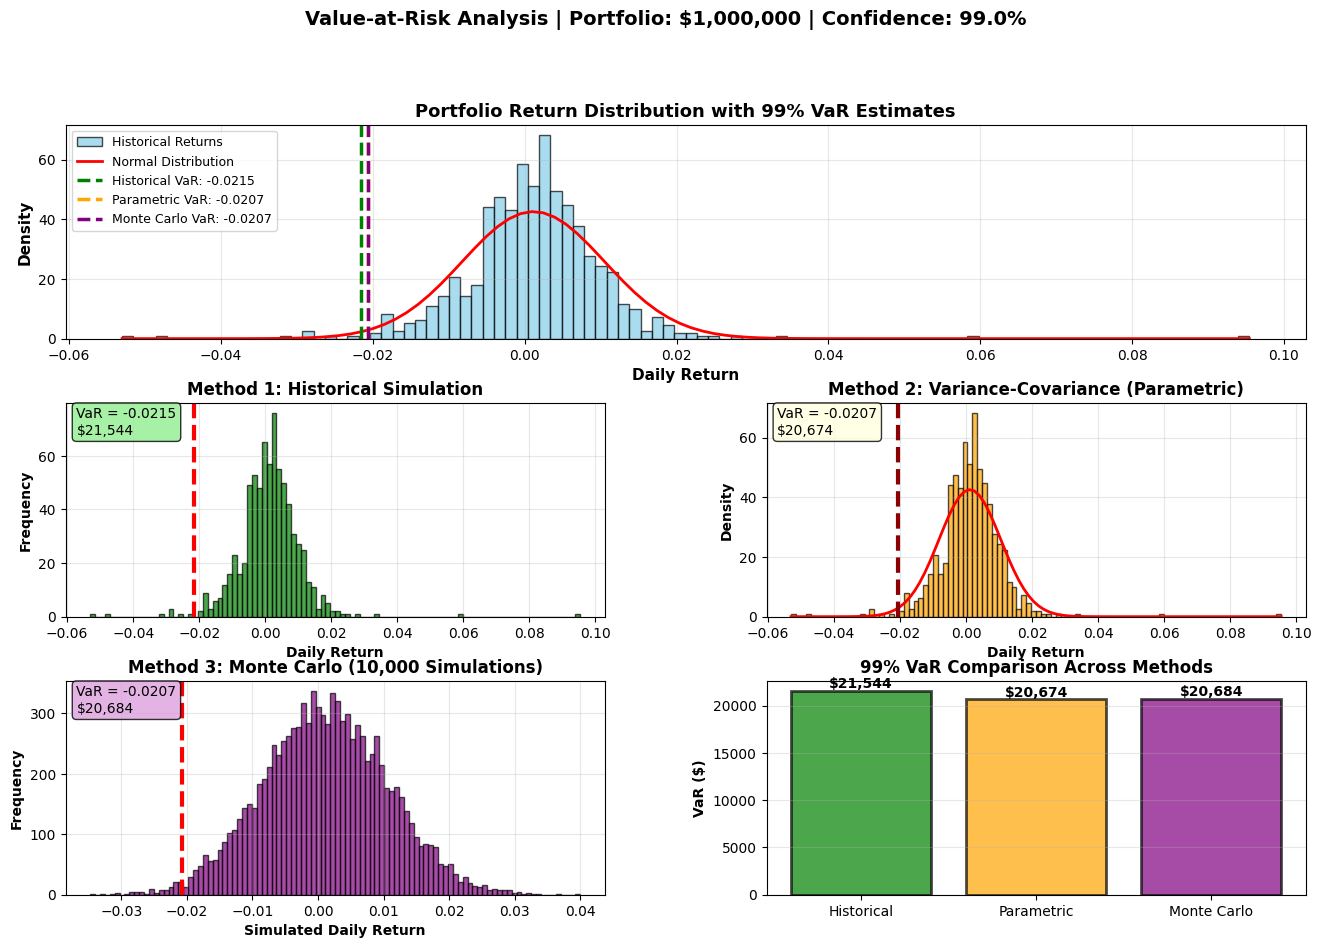

Chart saved: '03_var_comparison_all_methods.png'


In [9]:
# Create a comprehensive visualization
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# Plot 1: Portfolio Return Distribution with all VaR lines
ax1 = fig.add_subplot(gs[0, :])
ax1.hist(portfolio_returns, bins=100, density=True, alpha=0.7, 
         color='skyblue', edgecolor='black', label='Historical Returns')

# Overlay normal distribution
x = np.linspace(portfolio_returns.min(), portfolio_returns.max(), 100)
normal_dist = stats.norm.pdf(x, portfolio_mean, portfolio_std)
ax1.plot(x, normal_dist, 'r-', linewidth=2, label='Normal Distribution')

# Add VaR lines
ax1.axvline(var_historical_return, color='green', linestyle='--', linewidth=2.5, 
            label=f'Historical VaR: {var_historical_return:.4f}')
ax1.axvline(var_parametric_return, color='orange', linestyle='--', linewidth=2.5,
            label=f'Parametric VaR: {var_parametric_return:.4f}')
ax1.axvline(var_monte_carlo_return, color='purple', linestyle='--', linewidth=2.5,
            label=f'Monte Carlo VaR: {var_monte_carlo_return:.4f}')

ax1.set_xlabel('Daily Return', fontweight='bold', fontsize=11)
ax1.set_ylabel('Density', fontweight='bold', fontsize=11)
ax1.set_title('Portfolio Return Distribution with 99% VaR Estimates', 
              fontweight='bold', fontsize=13)
ax1.legend(loc='upper left', fontsize=9)
ax1.grid(True, alpha=0.3)

# Plot 2: Historical Simulation Detail
ax2 = fig.add_subplot(gs[1, 0])
ax2.hist(portfolio_returns, bins=100, alpha=0.7, color='green', edgecolor='black')
ax2.axvline(var_historical_return, color='red', linestyle='--', linewidth=3)
ax2.set_xlabel('Daily Return', fontweight='bold')
ax2.set_ylabel('Frequency', fontweight='bold')
ax2.set_title('Method 1: Historical Simulation', fontweight='bold')
ax2.text(0.02, 0.98, f'VaR = {var_historical_return:.4f}\n${var_historical_dollar:,.0f}',
         transform=ax2.transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
ax2.grid(True, alpha=0.3)

# Plot 3: Parametric Method with Normal Curve
ax3 = fig.add_subplot(gs[1, 1])
ax3.hist(portfolio_returns, bins=100, density=True, alpha=0.7, 
         color='orange', edgecolor='black')
x_range = np.linspace(portfolio_returns.min(), portfolio_returns.max(), 100)
ax3.plot(x_range, stats.norm.pdf(x_range, portfolio_mean, portfolio_std), 
         'r-', linewidth=2)
ax3.axvline(var_parametric_return, color='darkred', linestyle='--', linewidth=3)
ax3.set_xlabel('Daily Return', fontweight='bold')
ax3.set_ylabel('Density', fontweight='bold')
ax3.set_title('Method 2: Variance-Covariance (Parametric)', fontweight='bold')
ax3.text(0.02, 0.98, f'VaR = {var_parametric_return:.4f}\n${var_parametric_dollar:,.0f}',
         transform=ax3.transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
ax3.grid(True, alpha=0.3)

# Plot 4: Monte Carlo Simulation
ax4 = fig.add_subplot(gs[2, 0])
ax4.hist(simulated_portfolio_returns, bins=100, alpha=0.7, 
         color='purple', edgecolor='black')
ax4.axvline(var_monte_carlo_return, color='red', linestyle='--', linewidth=3)
ax4.set_xlabel('Simulated Daily Return', fontweight='bold')
ax4.set_ylabel('Frequency', fontweight='bold')
ax4.set_title(f'Method 3: Monte Carlo ({n_simulations:,} Simulations)', fontweight='bold')
ax4.text(0.02, 0.98, f'VaR = {var_monte_carlo_return:.4f}\n${var_monte_carlo_dollar:,.0f}',
         transform=ax4.transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='plum', alpha=0.8))
ax4.grid(True, alpha=0.3)

# Plot 5: VaR Comparison Bar Chart
ax5 = fig.add_subplot(gs[2, 1])
methods = ['Historical', 'Parametric', 'Monte Carlo']
var_values = [var_historical_dollar, var_parametric_dollar, var_monte_carlo_dollar]
colors = ['green', 'orange', 'purple']
bars = ax5.bar(methods, var_values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax5.set_ylabel('VaR ($)', fontweight='bold')
ax5.set_title('99% VaR Comparison Across Methods', fontweight='bold')
ax5.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, value in zip(bars, var_values):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height,
             f'${value:,.0f}',
             ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.suptitle(f'Value-at-Risk Analysis | Portfolio: ${portfolio_value:,} | Confidence: {confidence_level*100}%',
             fontsize=14, fontweight='bold', y=0.995)

plt.savefig('03_var_comparison_all_methods.png', dpi=300, bbox_inches='tight')
plt.show()

print("Chart saved: '03_var_comparison_all_methods.png'")


In [10]:
# Save VaR results
var_results = {
    'Portfolio_Value': portfolio_value,
    'Confidence_Level': confidence_level,
    'Historical_VaR_Return': var_historical_return,
    'Historical_VaR_Dollar': var_historical_dollar,
    'Parametric_VaR_Return': var_parametric_return,
    'Parametric_VaR_Dollar': var_parametric_dollar,
    'Monte_Carlo_VaR_Return': var_monte_carlo_return,
    'Monte_Carlo_VaR_Dollar': var_monte_carlo_dollar,
    'Portfolio_Mean': portfolio_mean,
    'Portfolio_Std': portfolio_std
}

# Save as DataFrame
var_results_df = pd.DataFrame([var_results])
var_results_df.to_csv('var_results.csv', index=False)

# Save portfolio returns for backtesting
portfolio_returns.to_csv('portfolio_returns.csv')

# Save simulated returns for analysis
pd.DataFrame(simulated_portfolio_returns, 
             columns=['Simulated_Return']).to_csv('monte_carlo_simulations.csv', index=False)

print("Files saved:")
print("- var_results.csv")
print("- portfolio_returns.csv")
print("- monte_carlo_simulations.csv")

Files saved:
- var_results.csv
- portfolio_returns.csv
- monte_carlo_simulations.csv


In [11]:
summary = f"""
THREE VAR METHODS SUCCESSFULLY CALCULATED

Portfolio Configuration:
  • Value: ${portfolio_value:,}
  • Assets: {', '.join(returns.columns)}
  • Equal-weighted allocation
  • Confidence Level: {confidence_level*100}%

VaR Results (1-Day, 99% Confidence):
  
  1️⃣  Historical Simulation:
      Return: {var_historical_return:.4f} ({var_historical_return*100:.2f}%)
      Dollar: ${var_historical_dollar:,.2f}
      
  2️⃣  Variance-Covariance (Parametric):
      Return: {var_parametric_return:.4f} ({var_parametric_return*100:.2f}%)
      Dollar: ${var_parametric_dollar:,.2f}
      
  3️⃣  Monte Carlo Simulation ({n_simulations:,} runs):
      Return: {var_monte_carlo_return:.4f} ({var_monte_carlo_return*100:.2f}%)
      Dollar: ${var_monte_carlo_dollar:,.2f}

Key Observations:
  • Most Conservative (Highest VaR): {var_comparison.loc[var_comparison['VaR ($)'].idxmax(), 'Method']}
  • Least Conservative (Lowest VaR): {var_comparison.loc[var_comparison['VaR ($)'].idxmin(), 'Method']}
  • Difference between methods: ${var_comparison['VaR ($)'].max() - var_comparison['VaR ($)'].min():,.2f}

  CRITICAL INSIGHT:
The variation between methods suggests different assumptions matter!
We need backtesting to see which method performs best.

"""

print(summary)



THREE VAR METHODS SUCCESSFULLY CALCULATED

Portfolio Configuration:
  • Value: $1,000,000
  • Assets: AAPL, MSFT, JPM, GLD, SPY
  • Equal-weighted allocation
  • Confidence Level: 99.0%

VaR Results (1-Day, 99% Confidence):

  1️⃣  Historical Simulation:
      Return: -0.0215 (-2.15%)
      Dollar: $21,543.70

  2️⃣  Variance-Covariance (Parametric):
      Return: -0.0207 (-2.07%)
      Dollar: $20,673.75

  3️⃣  Monte Carlo Simulation (10,000 runs):
      Return: -0.0207 (-2.07%)
      Dollar: $20,684.42

Key Observations:
  • Most Conservative (Highest VaR): Historical Simulation
  • Least Conservative (Lowest VaR): Variance-Covariance
  • Difference between methods: $869.95

  CRITICAL INSIGHT:
The variation between methods suggests different assumptions matter!
We need backtesting to see which method performs best.


